### TASK: SECRET 3

### Approach:
We first load the data that is already set up in the repository or can be obtained using get_data.ipynb <br>
Following the suggestion in the task we used bz and dst to compute correlations and models <br>
*  1.Correlation between the 2 variables: <br>
 * We computed covariance <br>
 * We computerd Pearson correlation <br>
* 2&3 Model: <br>
 * 2.Support vetor regreession (SVR) with nonlinear (RBF) kernel <br>
 * 3.Long Short Term Memory cell 

In [1]:
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from scipy.signal import correlate
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

### Load data

In [2]:
def load_data():
    with open('./dst_yearly/alldata_2000-2016.txt', 'r') as fd: 
        dst = pickle.load(fd)

    with open('./omni_bxe_bxm_hourly_averaged/alldata_2000-2016.txt') as fd:
        bz_e_m = pickle.load(fd)

    signal_1 = [pair[2] for pair in bz_e_m]
    signal_2 = [pair[1] for pair in dst]
    return signal_1, signal_2

## 1. stats; covariance and Pearson correlation

### We now load and plot the data

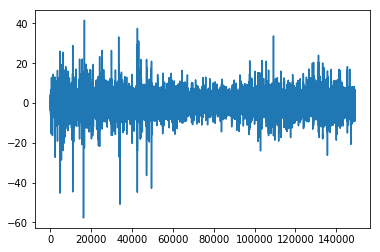

In [8]:
signal_1, signal_2 = load_data()
plt.plot(signal_1)

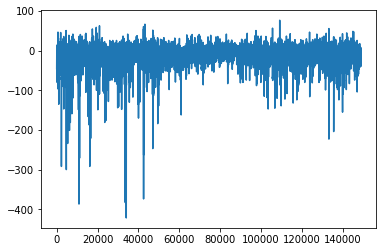

In [9]:
plt.plot(signal_2)

### We now compute and print the covariance and pearson values

In [5]:
def compute_covariance_and_pearson():
    data = np.vstack((np.array(signal_1)[np.newaxis],np.array(signal_2)[np.newaxis]))
    print "COVARIANCE"
    cov_data = np.cov(data)
    print cov_data
    print "PEARSON CORRELATION"
    corrcoef_data = np.corrcoef(data)
    print corrcoef_data
    return cov_data, corrcoef_data

_ = compute_covariance_and_pearson()

COVARIANCE
[[   9.38780097   19.52207619]
 [  19.52207619  431.85933148]]
PEARSON CORRELATION
[[ 1.          0.30660054]
 [ 0.30660054  1.        ]]


## 1. Results correlation
We computed Pearson correlation and covariance of the variables and based on the values we believe we can train a nonlinear regressor to fit the data well.

# 2. Support Vector Regressor (SVR) (skip to 2.2 if u don't want to wait for training)
We trained a support vector regreesor and did a hyperparameter search over the window size of the past bz and dst values

In [6]:
def train_SVR(past_size_bz, start_train, end_train, past_size_dst, test_start_idx, test_end_idx, C=1e3, gamma=0.1, verbose=False):
    """
    train SVR in a given setting

    Parameters
    ----------
    past_size_bz : int
        Size of past bz values to be used as features (including the one at the current moment)
    start_train : int 
        Index of the starting position in the dataset of the train subset
    end_train : int
        Index of the ending postion in the dataset of the train subset 
    past_size_dst : int
        Size of past dst values to be used as features (excluding the one at the current moment)
        0 means past dst values will not be used as features
    test_start_idx : int
        Index of the starting position in the dataset of the test subset
    test_end_idx : int 
        Index of the ending position in the dataset of the test subset
    C : float
        SVR parameter. Default C=1e3
    gamma : float
        SVR parameter. Default gamma=0.1
    verbose : boolean
        If True, we plot the predicted values of the testset and the ground truth

    Returns
    -------
    mse : int
        Mean Square Error of the prediction set vs the ground truth
    
    model : SVR
        A trained model
    """
    
    X = np.array([signal_1[idx-past_size_bz:idx] for idx in range(start_train,end_train,1)])
    if past_size_dst != 0:
        X = np.hstack((X,[signal_2[idx-past_size_dst-1:idx-1] for idx in range(start_train,end_train,1)]))
    if len(X.shape) == 1:
        mean = np.mean(X)
        std = np.std(X)
    else:
        mean = np.mean(X,axis=0)
        std = np.std(X,axis=0)
    
    X = (X - mean) / std
    
    #X = np.array(signal_1[0:1000]).reshape(-1,1)
    y = np.array(signal_2[start_train:end_train])
    svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
    model = svr_rbf.fit(X, y)
    
    test_X = np.array([signal_1[idx-past_size_bz:idx] for idx in range(test_start_idx,test_end_idx,1)])
    if past_size_dst != 0:
        test_X = np.hstack((test_X,[signal_2[idx-past_size_dst-1:idx-1] for idx in range(test_start_idx,test_end_idx,1)]))
    test_X = ( test_X - mean ) / std
    predictions = model.predict(test_X)
    gt = signal_2[test_start_idx:test_end_idx]
    mse = np.sum((predictions - gt)*(predictions - gt)) / len(predictions)
    
    if verbose == True:
        predictions = model.predict(test_X)
        plt.plot(predictions)
        gt = signal_2[test_start_idx:test_end_idx]
        plt.plot(gt)
    return mse, model

## 2.1 Hyperparameter search over the possible combination of features
* the number of past bz values [4, 8, 16]

In [7]:
start_train_ = 300
end_train_ = 10000

test_start_idx_ = end_train_
test_end_idx_ = end_train_ + 50000

verbose_=False

best_model_ = None
best_mse_ = 1000000

## VALIDATION and choosing hyperparameter
validation_history = []
for size1_ in [4, 8, 16]:
    row_ = []
    for size2_ in [0]:
        mse_, model_ = train_SVR(size1_, start_train_, end_train_, size2_, test_start_idx_, test_end_idx_, verbose=verbose_)
        if mse_ < best_mse_:
            best_mse_ = mse_
            best_model_ = model_
        row_.append((size1_, size2_, mse_))
        print(row_[-1])
    validation_history.append(row_)

(4, 0, 453.2443603704869)
(8, 0, 438.15043412069383)
(16, 0, 486.56813343933499)


Minimum_value:438.150434121
('best history len bz', 8)
('best history len dst', 0)


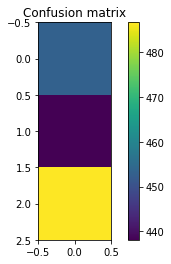

In [9]:
plt.imshow([[pair[2] for pair in row] for row in validation_history])
plt.colorbar()
plt.title('Confusion matrix')

print("Minimum_value:"+str(best_mse_))
minimum_pair_ = None
for row in validation_history:
    for pair in row:
        if pair[2] == best_mse_:
            minimum_pair_ = pair[:]

print('best history len bz', minimum_pair_[0])
print('best history len dst', minimum_pair_[1])

### The bast results are achieved by 8 past bz

### Train for longer with these parameters and test on unseen data

In [10]:
start_train_ = 300
end_train_ = 50000

test_start_idx_ = 50000 
test_end_idx_ = test_start_idx_ + 50000

verbose_=False

mse_, model_ = train_SVR(minimum_pair_[0], start_train_, end_train_, minimum_pair_[1], test_start_idx_, test_end_idx_, verbose=verbose_)
print("MSE="+str(mse_))

MSE=129.173013896


In [23]:
def save_svr_model(model, fname):
    import pickle
    with open ('./models/'+fname, 'w') as fd:
        pickle.dump(model, fd)

def load_svr_model(fname):
    import pickle
    with open ('./models/'+fname, 'r') as fd:
        model = pickle.load(fd)
    return model

In [ ]:
save_svr_model(model_)

## 2.2 SVR can be run from here and the model will be restored from file, no need to wait for training

In [3]:
def save_svr_model(model, fname):
    import pickle
    with open ('./models/'+fname, 'w') as fd:
        pickle.dump(model, fd)

def load_svr_model(fname):
    import pickle
    with open ('./models/'+fname, 'r') as fd:
        model = pickle.load(fd)
    return model

In [4]:
def predict_model(model, past_size_bz, past_size_dst, start_train, end_train, test_start_idx, test_end_idx):
    # RETURNS ground_truth, predictions, mse on the test_set
    X = np.array([signal_1[idx-past_size_bz:idx] for idx in range(start_train,end_train,1)])

    if past_size_dst != 0:
        X = np.hstack((X,[signal_2[idx-past_size_dst-1:idx-1] for idx in range(start_train,end_train,1)]))

    mean = np.mean(X,axis=0)
    std = np.std(X,axis=0)

    test_X = np.array([signal_1[idx-past_size_bz:idx] for idx in range(test_start_idx,test_end_idx,1)])
    if past_size_dst != 0:
        test_X = np.hstack((test_X,[signal_2[idx-past_size_dst-1:idx-1] for idx in range(test_start_idx,test_end_idx,1)]))
    test_X = ( test_X - mean ) / std
    predictions = model.predict(test_X)
    gt = signal_2[test_start_idx:test_end_idx]
    mse = np.sum((predictions - gt)*(predictions - gt)) / len(predictions)
    return gt, predictions, mse

### This will take a while because we parse and predict on the shole dataset ( 2-3 minutes )

In [10]:
start_train_ = 300
end_train_ = 50000

test_start_idx_ = 50000 
test_end_idx_ = test_start_idx_ + 50000

past_size_bz_ = 8
past_size_dst_ = 0

model_ = load_svr_model('SVR-model_past-dst:0_past-bz:8.weights')
gt_, predictions_, mse_ = predict_model(model_, past_size_bz_, past_size_dst_, start_train_, end_train_, test_start_idx_, test_end_idx_)

In [11]:
def plot_data(predictions, gt, label_str):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    ax1.title.set_text('prediction')
    ax1.plot(predictions)
    x1,x2,y1,y2 = ax1.axis()
    ax1.axis((x1,x2,-200,50))

    ax2 = fig.add_subplot(212)
    ax2.title.set_text('ground truth')
    ax2.plot(gt)
    x1,x2,y1,y2 = ax2.axis()
    ax2.axis((x1,x2,-200,50))
    fig.suptitle(label_str+" from the test_set")
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

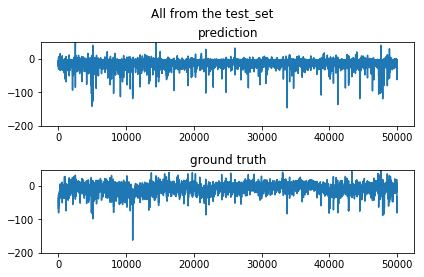

In [12]:
plot_data(predictions_, gt_, "All")

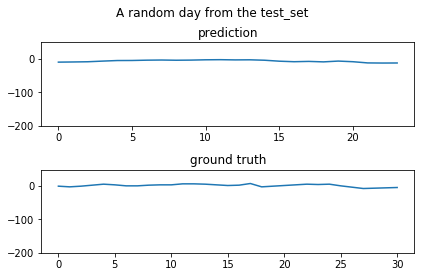

In [13]:
random_index = np.random.randint(0, len(predictions_)-24)
plot_data(predictions_[random_index:random_index+24], gt_[random_index:random_index+31], 'A random day')

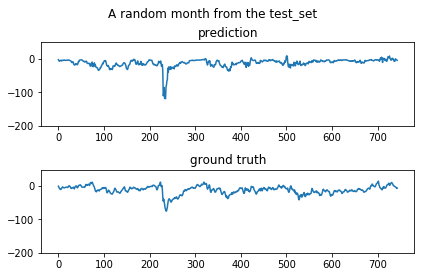

In [14]:
random_index = np.random.randint(0, len(predictions_)-24*31)
plot_data(predictions_[random_index:random_index+24*31], gt_[random_index:random_index+24*31], 'A random month')

### Results SVR
At the moment we achieved visible progress and 129.63 MSE <br>
For this we used SVM for regression that takes as input at each timestep 8 previous bz values

# 3. RNN & LSTM 
We now see that we got nice results based on just these features but we want to see if we can do better than 17 Mean squared error by training a Neural Network, more specifically a Recurrent Neural Network, which specializes in time series data.

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


### 3.1 My Wrapper of the LSTM

In [4]:


class LSTM_Keras:
    
    @staticmethod
    def get_model(nr_neurons, nr_features):
        model = Sequential()
        model.add(LSTM(nr_neurons, batch_input_shape=(1, 1, nr_features), batch_size=1, stateful=True))
        model.add(Dense(1))
        return model
        
    @staticmethod
    def train_lstm(X, y, nr_neurons, nr_epochs, save_model = False, validation_split = 0):
        model = LSTM_Keras.get_model(nr_neurons, X.shape[1])
        X = X.reshape(X.shape[0], 1, X.shape[1])
        model.compile(loss='mean_squared_error', optimizer='adam')
        
        # checkpoint
        callbacks_list = []
        if save_model == True:
            filename = make_filename(nr_neurons, nr_epochs, 0, 1)
            checkpoint = ModelCheckpoint('./models/'+filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
            
            stopping = EarlyStopping(monitor='val_loss', min_delta=5, patience=5, verbose=1, mode='min')
            
            callbacks_list = [checkpoint, stopping]
        
        history = model.fit(X, y, epochs=nr_epochs, batch_size=1, verbose=2, shuffle=False, callbacks=callbacks_list, validation_split=validation_split)
        return model, history
    
    @staticmethod
    def predict_lstm(model, X):
        # make a prediction
        X = X.reshape(1, 1, len(X))
        pred = model.predict(X, batch_size=1)
        return pred[0,0]
    
    @staticmethod
    def forward_model(model, X):
        # forecast the entire set X to build up state
        train_reshaped = X.reshape(X.shape[0], 1, X.shape[1])
        model.reset_states()
        predictions = model.predict(train_reshaped,batch_size=1)
        return predictions
    
    @staticmethod
    def save_model(model, filename):
        model.save_weights('./models/'+filename)

    @staticmethod
    def load_model(filename, neurons, nr_features):
        some_model = LSTM_Keras.get_model(neurons, nr_features)
        some_model.load_weights('./models/'+filename, by_name=False)
        return some_model
    
    @staticmethod
    def evaluate_model(model, X_train, X_test, y_test):
        # RETURNS ground_truth, predictions, mse of the model on the test set
        LSTM_Keras.forward_model(model,X_train)
        
        predictions = list()
        gt = []
        for i in range(len(X_test)):
            # make one-step forecast
            pred = LSTM_Keras.predict_lstm(model, X_test[i])
            # store forecast
            predictions.append(pred)
            expected = y_test[i]
            gt.append(expected)

        # report performance
        mse = mean_squared_error(gt[:], predictions)
        return gt, predictions, mse
    
def make_filename(neurons_nr, epochs_nr, past_size_dst, past_size_bz):
    file_name = "lstm-model_neurons:"+str(neurons_nr)+"_epochs:"+str(epochs_nr)+ \
            "_past-dst:"+str(past_size_dst)+"_past-bz:"+str(past_size_bz)+".weights"
    return file_name

### Parameters

In [25]:
past_size_bz_ = 1
past_size_dst_ = 0

start_train_ = 100
end_train_ = 10000 # 10000 is a little over 13 months
test_start_idx_ = end_train_
test_end_idx_ = end_train_ + 50000

signal_1, signal_2 = load_data()

X_ = np.array([signal_1[idx-past_size_bz_:idx] for idx in range(start_train_,test_end_idx_,1)])
if past_size_dst_ != 0:
    X_ = np.hstack((X_,[signal_2[idx-past_size_dst_-1:idx-1] for idx in range(start_train_,test_end_idx_,1)]))
y_ = np.array(signal_2[start_train_:test_end_idx_])

histories_ = []

### 3.2 Training & Hyperparameter search (skip to 3.3 if you only want to load model)
* Searched for the number of neurons in the LSTM [4, 8, 16]

In [26]:
epochs_nr_ = 20

best_model_ = None
best_mse_ = 100000
best_neurons_nr_ = 0

for neurons_nr_ in [4, 8, 16]:
    model1_, history_ = LSTM_Keras.train_lstm(X_[start_train_:end_train_], y_[start_train_:end_train_], neurons_nr_, epochs_nr_)

    _, _, mse_ = LSTM_Keras.evaluate_model(model1_, X_[start_train_:end_train_], X_[test_start_idx_:test_end_idx_], y_[test_start_idx_:test_end_idx_])
    print('Test MSE '+str(neurons_nr_)+' neurons: %.3f' % mse_)
    
    histories_.append((neurons_nr_, mse_, history_))
    if best_mse_ > mse_:
        best_mse_ = mse_
        best_model_ = model1_
        best_neurons_nr_ = neurons_nr_
        
    LSTM_Keras.save_model(model1_,make_filename(neurons_nr_, epochs_nr_, past_size_dst_, past_size_bz_))

#print(histories)

Epoch 1/20
30s - loss: 803.6148
Epoch 2/20
31s - loss: 708.3077
Epoch 3/20
30s - loss: 652.6824
Epoch 4/20
29s - loss: 639.8804
Epoch 5/20
29s - loss: 651.9369
Epoch 6/20
29s - loss: 607.7620
Epoch 7/20
31s - loss: 523.6047
Epoch 8/20
31s - loss: 493.4083
Epoch 9/20
34s - loss: 455.2201
Epoch 10/20
34s - loss: 443.9308
Epoch 11/20
34s - loss: 441.4659
Epoch 12/20
34s - loss: 417.4342
Epoch 13/20
34s - loss: 420.2778
Epoch 14/20
34s - loss: 398.0563
Epoch 15/20
34s - loss: 393.8797
Epoch 16/20
34s - loss: 400.0150
Epoch 17/20
34s - loss: 392.4395
Epoch 18/20
34s - loss: 376.3243
Epoch 19/20
34s - loss: 380.5287
Epoch 20/20
34s - loss: 373.9999
Test MSE 4 neurons: 586.571
Epoch 1/20
31s - loss: 730.0980
Epoch 2/20
30s - loss: 584.3944
Epoch 3/20
31s - loss: 528.3461
Epoch 4/20
31s - loss: 496.6929
Epoch 5/20
30s - loss: 439.9011
Epoch 6/20
32s - loss: 422.3817
Epoch 7/20
32s - loss: 400.2962
Epoch 8/20
32s - loss: 437.9314
Epoch 9/20
32s - loss: 383.2714
Epoch 10/20
35s - loss: 456.1997


NameError: name 'histories' is not defined

### Learning curve of best number of neurons

Best nr of neurons: 4


Text(0.5,1,'Loss functin during training for 4 neurons')

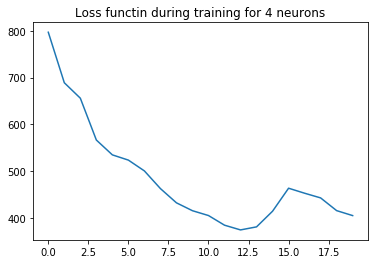

In [57]:
print "Best nr of neurons: " + str(best_neurons_nr_)
plt.plot(histories_[0][-1].history['loss'])
plt.title('Loss functin during training for 4 neurons')

### Train more with 4 neurons to see how good we can get

In [105]:
neurons_nr_ = 4
epochs_nr_ = 60

start_train_ = 100
end_train_ = 40000 # 10000 is a little over 13 months
test_start_idx_ = end_train_
test_end_idx_ = end_train_ + 50000
X_ = np.array([signal_1[idx-past_size_bz_:idx] for idx in range(start_train_,test_end_idx_,1)])
if past_size_dst_ != 0:
    X_ = np.hstack((X_,[signal_2[idx-past_size_dst_-1:idx-1] for idx in range(start_train_,test_end_idx_,1)]))
y_ = np.array(signal_2[start_train_:test_end_idx_])

model1_, history_ = LSTM_Keras.train_lstm(X_[start_train_:end_train_], y_[start_train_:end_train_], neurons_nr_, epochs_nr_, save_model=True, validation_split=0.25)

_, _, mse_ = LSTM_Keras.evaluate_model(model1_, X_[start_train_:end_train_], X_[test_start_idx_:test_end_idx_], y_[test_start_idx_:test_end_idx_])
print('Test MSE '+str(neurons_nr_)+' neurons: %.3f' % mse_)

histories_.append((neurons_nr_, mse_, history_))
if best_mse_ > mse_:
    best_mse_ = mse_
    best_model_ = model1_
    best_neurons_nr_ = neurons_nr_

#LSTM_Keras.save_model(model1_,make_filename(neurons_nr_, epochs_nr_, past_size_dst_, past_size_bz_))

Train on 29925 samples, validate on 9975 samples
Epoch 1/60
Epoch 00000: val_loss improved from inf to 794.06239, saving model to ./models/lstm-model_neurons:4_epochs:60_past-dst:0_past-bz:1.weights
144s - loss: 758.7454 - val_loss: 794.0624
Epoch 2/60
Epoch 00001: val_loss improved from 794.06239 to 701.73789, saving model to ./models/lstm-model_neurons:4_epochs:60_past-dst:0_past-bz:1.weights
131s - loss: 527.0005 - val_loss: 701.7379
Epoch 3/60
Epoch 00002: val_loss did not improve
143s - loss: 448.9766 - val_loss: 710.7948
Epoch 4/60
Epoch 00003: val_loss did not improve
134s - loss: 534.3966 - val_loss: 736.4088
Epoch 5/60
Epoch 00004: val_loss did not improve
139s - loss: 537.5652 - val_loss: 734.1825
Epoch 6/60
Epoch 00005: val_loss did not improve
137s - loss: 459.4779 - val_loss: 726.8169
Epoch 7/60
Epoch 00006: val_loss did not improve
135s - loss: 408.4462 - val_loss: 776.9166
Epoch 8/60
Epoch 00007: val_loss improved from 701.73789 to 683.28164, saving model to ./models/lst

LSTM 4 Neurons: MSE on test set: 349.668542725


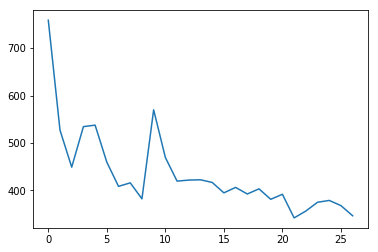

In [109]:
plt.plot(histories_[-1][-1].history['loss'])
print("LSTM 4 Neurons: MSE on test set: "+str(mse_))

## 3.3 Load model (from where the validation loss was the best) from file and predict values for all test; random month and random day in the test set

In [27]:
def plot_data(predictions, gt, label_str):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    ax1.title.set_text('prediction')
    ax1.plot(predictions)
    x1,x2,y1,y2 = ax1.axis()
    ax1.axis((x1,x2,-200,50))

    ax2 = fig.add_subplot(212)
    ax2.title.set_text('ground truth')
    ax2.plot(gt)
    x1,x2,y1,y2 = ax2.axis()
    ax2.axis((x1,x2,-200,50))
    fig.suptitle(label_str+" from the test_set")
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

neurons_nr_ = 4
epochs_nr_ = 60

start_train_ = 100
end_train_ = 40000 # 10000 is a little over 13 months
test_start_idx_ = end_train_
test_end_idx_ = end_train_ + 50000
past_size_bz_ = 1
past_size_dst_ = 0

signal_1, signal_2 = load_data()

X_ = np.array([signal_1[idx-past_size_bz_:idx] for idx in range(start_train_,test_end_idx_,1)])
if past_size_dst_ != 0:
    X_ = np.hstack((X_,[signal_2[idx-past_size_dst_-1:idx-1] for idx in range(start_train_,test_end_idx_,1)]))
y_ = np.array(signal_2[start_train_:test_end_idx_])

In [28]:
best_model_ =  LSTM_Keras.load_model('lstm-model_neurons:4_epochs:60_past-dst:0_past-bz:1.weights', neurons_nr_, 1)
gt_, predictions_, mse_ = LSTM_Keras.evaluate_model(best_model_, X_[start_train_:end_train_], X_[test_start_idx_:test_end_idx_], y_[test_start_idx_:test_end_idx_])

In [29]:
print("Best model Test data MSE: " + str(mse_))

Best model Test data MSE: 290.015648088


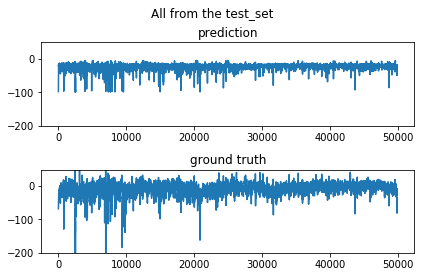

In [18]:
plot_data(predictions_, gt_, "All")

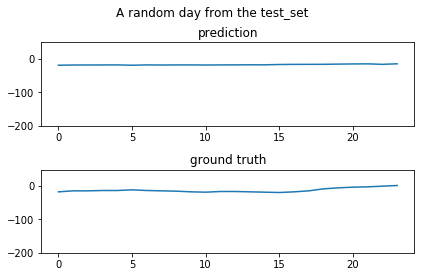

In [19]:
random_index = np.random.randint(0, len(predictions_)-24)
plot_data(predictions_[random_index:random_index+24], gt_[random_index:random_index+24], 'A random day')

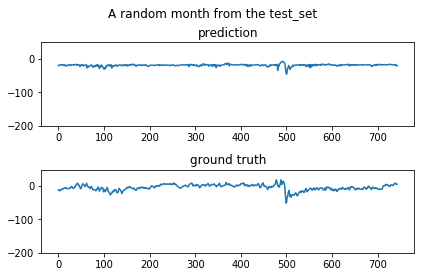

In [20]:
random_index = np.random.randint(0, len(predictions_)-24*31)
plot_data(predictions_[random_index:random_index+24*31], gt_[random_index:random_index+24*31], 'A random month')